In [1]:
!pip install inference inference-gpu supervision opencv-python

  Using cached inference-0.23.0-py3-none-any.whl.metadata (14 kB)
  Using cached inference_gpu-0.23.0-py3-none-any.whl.metadata (14 kB)
  Using cached supervision-0.24.0-py3-none-any.whl.metadata (14 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached aiortc-1.9.0-cp38-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached APScheduler-3.10.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached Cython-3.0.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached fastapi-0.110.3-py3-none-any.whl.metadata (24 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached piexif-1.1.3-py2.py3-none-any.whl.metadata (3.7 kB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached prometheus_fastapi_instrumentator-6.0.0-py3-none-any.whl.metadata (13 kB)
  Using cached redis-5.1.1-py3-none-any.whl.metadata (9.1 kB)
  Using c


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install torch

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/203.1 MB 3.1 MB/s eta 0:01:07
   ---------------------------------------- 0.2/203.1 MB 2.9 MB/s eta 0:01:11
   ---------------------------------------- 0.3/203.1 MB 2.5 MB/s eta 0:01:23
   ---------------------------------------- 0.4/203.1 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 0.5/203.1 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 0.6/203.1 MB 2.9 MB/s eta 0:01:11
   ---------------------------------------- 0.8/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 0.9/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 1.0/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 1.1/203.1 MB 2.8 MB/s eta 0:01:12
   ---------------------------------------- 1.2/203.1 MB 3.0 MB/s eta 0:01:09



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Training on GPU!")
else:
    print("CUDA is not available. Training on CPU.")

CUDA is not available. Training on CPU.


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


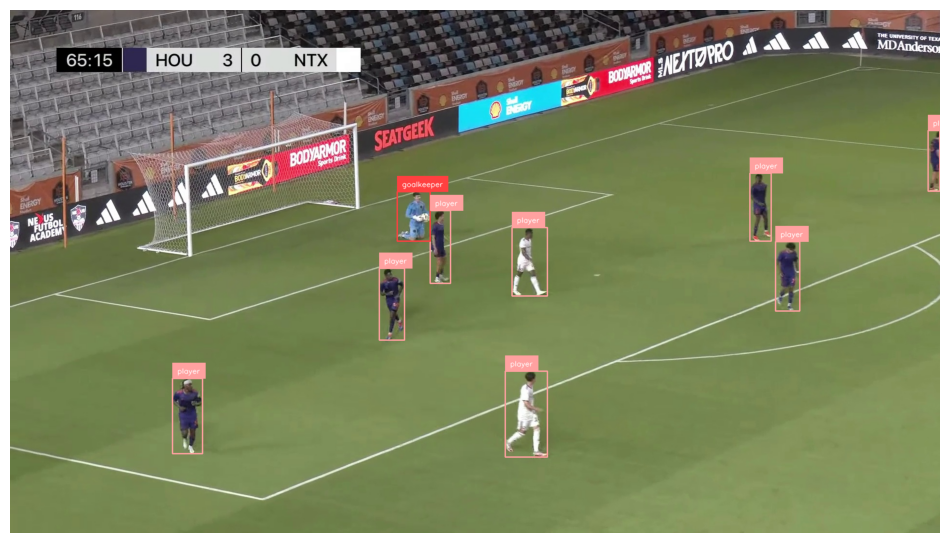

In [11]:
from inference import get_model
import supervision as sv
import cv2

# define the image url to use for inference
image_file = "images-object/frame800.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
objectModel = get_model(model_id="soccer-computer-vision-acffy/3")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.

results = objectModel.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

In [12]:
import supervision as sv
import os

sourceVideoPath = "C:\\Users\\isss1\\OneDrive\\Documents\\Wondershare\\Wondershare Filmora\\Output\\clip_12.mp4"

boxAnnotator = sv.BoxAnnotator()
labelAnnotator = sv.LabelAnnotator()

def getAnnotatedFrame(frame, index):
    result = objectModel.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    labels = [f"{className} {confidence:.2f}" for className, confidence in zip(detections['class_name'], detections.confidence)]

    annotatedFrame = frame.copy()
    annotatedFrame = boxAnnotator.annotate(scene=annotatedFrame, detections=detections)
    annotatedFrame = labelAnnotator.annotate(scene=annotatedFrame, detections=detections, labels=labels)

    return annotatedFrame

outputFolder = "annotated-footage"

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

print("Creating sample footage, please wait...")
sv.process_video(source_path=sourceVideoPath, target_path=f'{outputFolder}/annotated.mp4', callback=getAnnotatedFrame)
print(f"Finished creating sample footage. Check the {outputFolder} folder.")

Creating sample footage, please wait...
Finished creating sample footage. Check the annotated-footage folder.


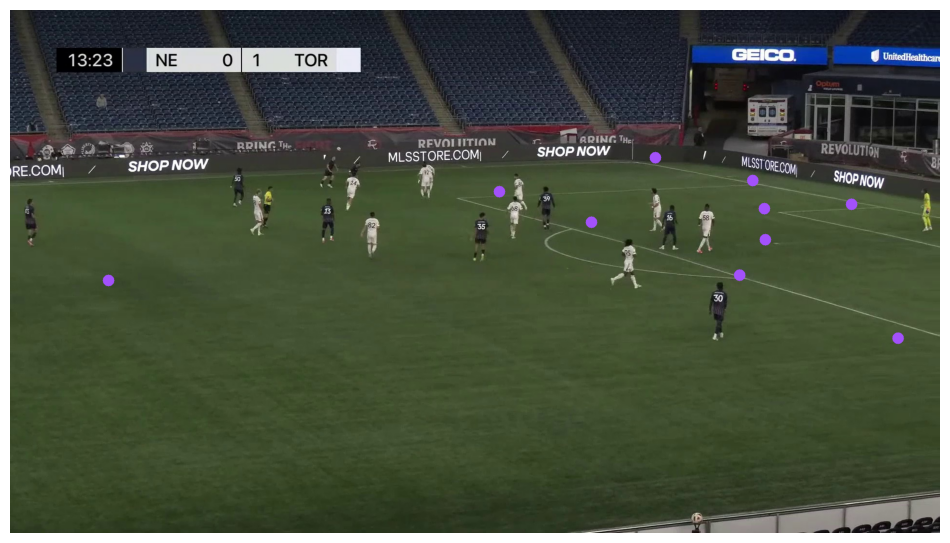

In [18]:
import supervision as sv
from inference import get_model
import numpy as np

# Keypoint Detection
# TODO: Using someone else's model so that I can implement some of the keypoint detection stuff, plan to use my own dataset
keypointModel = get_model(model_id="football-field-detection-f07vi/14")

print(keypointModel)

image_file = "images-pitch/frame152.jpg"
image = cv2.imread(image_file)

result = keypointModel.infer(image, confidence=0.3)[0]
keypoints = sv.KeyPoints.from_inference(result)

filter = keypoints.confidence > 0.5
keypoints.xy = keypoints.xy[filter][np.newaxis]

vertex_annotator = sv.VertexAnnotator(radius=12)
annotated_image = vertex_annotator.annotate(image.copy(), keypoints)

sv.plot_image(annotated_image)